# Preface
In this project, we aim to classify sleep stages using EEG brain signal sequence.The dataset consists of EEG sequences of 3000-time steps each and coming from two electrode locations on the head (Fpz-Cz and Pz-Oz) sampled at 100 Hz. That means that each sample contains two signals of 3000 samples and that those samples correspond to 30 seconds of recording.

The labels specify six stages of sleep as follows:

Label | Stage | Typical Frequencies (Hz)
---- | ---- | ----
0 | R | 15 - 30
1 | 1 | 4 - 8
2 | 2 | 8 - 15
3 | 3 | 1 - 4
4 | 4 | 0.5 - 2
5 | W | 15-50

W corresponds to the Wake stage, and R to REM sleep also called rapid eye movement, and most commonly known as the dreaming stage. Each sequence in the data set contains only one stage, which is specified by the corresponding label.



# Classification
We deploy 2 Deep learning algorithms, namely:
1. 2D Convolutional
2. 2D Convolutional + LSTM

From our experiment, we find 2D Convolutional yields the highest accuracy among all algorithm. We further perform grid search the find the best hyperparameter setting in this algorithm.


In this section, we first load the dataset and proceed to train each algorithm. 

In [1]:
import pickle
from google.colab import drive

drive.mount('/content/drive')

dataset_train = pickle.load(open('/content/drive/My Drive/Deep Learning Challenge/Dataset/Data_Spectrograms.pkl', 'rb'))
dataset_test = pickle.load(open('/content/drive/My Drive/Deep Learning Challenge/Dataset/Test_Spectrograms_no_labels.pkl', 'rb'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
# Sanity Check
print('Type of dataset_train is {}'.format(type(dataset_train)))
print('Type of dataset_test is {} \n'.format(type(dataset_test)))

# Check the length of each dataset
print('Length of dataset_train is {}'.format(len(dataset_train)))
print('Length of dataset_test is {} \n'.format(len(dataset_test)))

# Check element of dataset_train
print('The shape of first element in dataset_train is {}'.format(dataset_train[0].shape))
print('The shape of second element in dataset_train is {} \n'.format(dataset_train[1].shape))

# Check alement of dataset_test
print('The shape of first element in dataset_test is {}'.format(dataset_test[0].shape))


Type of dataset_train is <class 'list'>
Type of dataset_test is <class 'list'> 

Length of dataset_train is 2
Length of dataset_test is 1 

The shape of first element in dataset_train is (15375, 2, 100, 30)
The shape of second element in dataset_train is (15375,) 

The shape of first element in dataset_test is (1754, 2, 100, 30)


From the code above, we can observe that the dataset comes in a nested list. For dataset_train, it consist of 15,375 observation, 2 channels (Fpz-Cz and Pz-Oz), 100 Hz, and 30 timesteps, and the second element is the corresponding labels. 

## 2D Convolutional

After loading the dataset, we proceed with loading all necessary libraries and begin data management routines: reshape and split data into training and test set. From our evaluation, we found our model yield in 92.7% accuracy in training and 85.7% accuracy in validation set. Training time for this model is 9 minutes and 8 seconds.

In [0]:
### ------------------------------------------------------------------------ ###
### ---------------------   Load necessary libraries   --------------------- ###
### ------------------------------------------------------------------------ ###

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from datetime import datetime

### ------------------------------------------------------------------------ ###
### ---------------------   Data management routines   --------------------- ###
### ------------------------------------------------------------------------ ###

### Split dataset_train into training data and training label -------------- ###
conv2D_trainspc = dataset_train[0]
conv2D_trainlbl = dataset_train[1]

### Do the same for dataset_test ------------------------------------------- ###
conv2D_test = dataset_test[0]

### Reshape both data to move channel information to last ------------------ ###
conv2D_trainspc_reshaped = conv2D_trainspc.reshape(conv2D_trainspc.shape[0], 
                                                   conv2D_trainspc.shape[2], 
                                                   conv2D_trainspc.shape[3], 
                                                   conv2D_trainspc.shape[1])
conv2D_test_reshaped = conv2D_test.reshape(conv2D_test.shape[0], 
                                           conv2D_test.shape[2], 
                                           conv2D_test.shape[3], 
                                           conv2D_test.shape[1])

### Convert training label into categorical -------------------------------- ###
conv2D_catlabel = to_categorical(conv2D_trainlbl)

### Split dataset into training and validation set ------------------------- ###
X_train, X_val, y_train, y_val = train_test_split(conv2D_trainspc_reshaped, 
                                                  conv2D_catlabel,
                                                  test_size = 0.2,
                                                  random_state = 24)


Training Initiated at 2020-03-15 11:13:51.888298


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 15, 128)       0

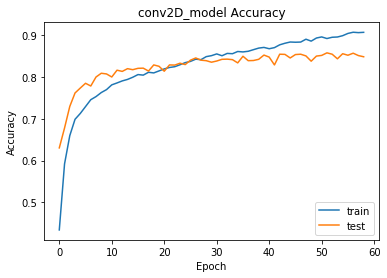

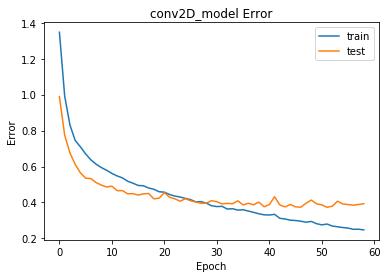


 
 Model is saved/content/drive/My Drive/TMP/Best Model/Best Model.h5


In [0]:
### ------------------------------------------------------------------------ ###
### ------------------------   Training the Model   ------------------------ ###
### ------------------------------------------------------------------------ ###

### Create Time Stamp ------------------------------------------------------ ###
start = datetime.now()
print("="*80)
print("Training Initiated at", start)
print("="*80,"\n\n")

### Define Saving Directory ------------------------------------------------ ###
saving_dir = '/content/drive/My Drive/TMP/'
model_name = 'Best Model' # Change to relative Path later in grid search
os.mkdir(saving_dir+model_name+'/')
saving_dir = saving_dir+model_name+'/'

### Define the model ------------------------------------------------------- ###
conv2D_model = Sequential()

conv2D_model.add(Conv2D(64, kernel_size=(3, 3), activation='tanh',
                        input_shape =X_train.shape[1:] ,padding='same'))
conv2D_model.add(LeakyReLU(alpha=0.1))
conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
conv2D_model.add(Dropout(0.1))

conv2D_model.add(Conv2D(128, (3, 3), activation='tanh',
                        padding='same'))
conv2D_model.add(LeakyReLU(alpha=0.1))
conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
conv2D_model.add(Dropout(0.3))

conv2D_model.add(Conv2D(256, (3, 3), activation='tanh',
                        padding='same'))
conv2D_model.add(LeakyReLU(alpha=0.1))
conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
conv2D_model.add(Dropout(0.5))

conv2D_model.add(Flatten())
conv2D_model.add(Dense(128, activation='tanh'))
conv2D_model.add(LeakyReLU(alpha=0.1))
conv2D_model.add(Dropout(0.5))
conv2D_model.add(Dense(6, activation = 'softmax'))

conv2D_model.summary()

conv2D_model.compile(loss = "categorical_crossentropy",
                     optimizer = Adam(lr = 1e-4, decay = 1e-15),
                     metrics = ["categorical_accuracy"])


cb = [ModelCheckpoint(
        filepath=saving_dir+"{} CP.hdf5".format(model_name),
        verbose=1, save_best_only=True),
      EarlyStopping(monitor = "val_loss", patience = 7, mode = "min", verbose = 1)]
conv2D_model_result = conv2D_model.fit(X_train, y_train, epochs = 1000, batch_size = 32,
                           validation_split = 0.2,
                           callbacks = cb, verbose = 1)

# Checkpoint
cp = datetime.now() - start
print("="*80)
print("Training time", cp)
print("="*80,"\n\n")

# conv2D_model Evaluation
# Load the best weight conv2D_model
conv2D_model.load_weights(saving_dir+"{} CP.hdf5".format(model_name))
_, train_acc = conv2D_model.evaluate(X_train, y_train, verbose=1)
_, val_acc = conv2D_model.evaluate(X_val, y_val, verbose=1)
print("\n\n")
print("="*80)
print("Evaluation on the best conv2D_model")
print('Train: %.3f \nTest: %.3f' % (train_acc, val_acc))
print("="*80, "\n")

plt.plot(conv2D_model_result.history['categorical_accuracy'], label='train')
plt.plot(conv2D_model_result.history['val_categorical_accuracy'], label='test')
plt.title("conv2D_model Accuracy")
plt.legend(["train", "test"], loc = "lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
print("\n")
print("="*80, "\n")


plt.plot(conv2D_model_result.history['loss'], label='train')
plt.plot(conv2D_model_result.history['val_loss'], label='test')
plt.title("conv2D_model Error")
plt.legend(["train", "test"], loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

# Save current conv2D_model
conv2D_model.save(saving_dir+"{}.h5".format(model_name))
print('\n \n Model is saved'+saving_dir+"{}.h5".format(model_name))

### Grid search

In order for finding the best hyperparameter tuning for this algorithm, we perform grid search. After we test different hyperparameter setting, we find that the best performance is achieved with $lr = 0.0001$ and $batch size = 32$

In [0]:
def grid_search(lr, batch_size, saving_dir):
  ### ------------------------------------------------------------------------ ###
  ### ------------------------   Training the Model   ------------------------ ###
  ### ------------------------------------------------------------------------ ###

  ### Create Time Stamp ------------------------------------------------------ ###
  start = datetime.now()
  print("="*80)
  print("Training Initiated at", start)
  print("="*80,"\n\n")
  ### ------------------------------------------------------------------------ ###


  ### Define Saving Directory ------------------------------------------------ ###
  model_name = 'lr {} batch size {}/'.format(str(lr), str(batch_size)) 
  os.makedirs(saving_dir+model_name)
  saving_dir = saving_dir+model_name
  ### ------------------------------------------------------------------------ ###


  conv2D_model = Sequential()

  conv2D_model.add(Conv2D(64, kernel_size=(3, 3), activation='tanh',
                          input_shape =X_train.shape[1:] ,padding='same'))
  conv2D_model.add(LeakyReLU(alpha=0.1))
  conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
  conv2D_model.add(Dropout(0.1))

  conv2D_model.add(Conv2D(128, (3, 3), activation='tanh',
                          padding='same'))
  conv2D_model.add(LeakyReLU(alpha=0.1))
  conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
  conv2D_model.add(Dropout(0.3))

  conv2D_model.add(Conv2D(256, (3, 3), activation='tanh',
                          padding='same'))
  conv2D_model.add(LeakyReLU(alpha=0.1))
  conv2D_model.add(MaxPooling2D((2, 2),padding='same'))
  conv2D_model.add(Dropout(0.5))

  conv2D_model.add(Flatten())
  conv2D_model.add(Dense(128, activation='tanh'))
  conv2D_model.add(LeakyReLU(alpha=0.1))
  conv2D_model.add(Dropout(0.5))
  conv2D_model.add(Dense(6, activation = 'softmax'))

  conv2D_model.summary()

  conv2D_model.compile(loss = "categorical_crossentropy",
                      optimizer = Adam(lr = lr, decay = 1e-15),
                      metrics = ["categorical_accuracy"])


  cb = [ModelCheckpoint(
          filepath=saving_dir+"Model CP.hdf5",
          verbose=1, save_best_only=True),
        EarlyStopping(monitor = "val_loss", patience = 7, mode = "min", verbose = 1)]
  conv2D_model_result = conv2D_model.fit(X_train, y_train, epochs = 1000, batch_size = batch_size,
                            validation_split = 0.2,
                            callbacks = cb, verbose = 1)

  # Checkpoint
  cp = datetime.now() - start
  print("="*80)
  print("Training time", cp)
  print("="*80,"\n\n")
  #-------------------------------------#

  # conv2D_model Evaluation
  # Load the best weight conv2D_model
  conv2D_model.load_weights(saving_dir+"Model CP.hdf5")
  _, train_acc = conv2D_model.evaluate(X_train, y_train, verbose=1)
  _, val_acc = conv2D_model.evaluate(X_val, y_val, verbose=1)
  print("\n\n")
  print("="*80)
  print("Evaluation on the best conv2D_model")
  print('Train: %.3f \nTest: %.3f' % (train_acc, val_acc))
  print("="*80, "\n")

  plt.plot(conv2D_model_result.history['categorical_accuracy'], label='train')
  plt.plot(conv2D_model_result.history['val_categorical_accuracy'], label='test')
  plt.title("conv2D_model Accuracy")
  plt.legend(["train", "test"], loc = "lower right")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.savefig(saving_dir+"Model Accuracy.png", dpi = 500, bbox_inches = 'tight')
  plt.show()
  
  print("\n")
  print("="*80, "\n")


  plt.plot(conv2D_model_result.history['loss'], label='train')
  plt.plot(conv2D_model_result.history['val_loss'], label='test')
  plt.title("conv2D_model Error")
  plt.legend(["train", "test"], loc = "upper right")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.savefig(saving_dir+"Model Loss.png", dpi = 500, bbox_inches = 'tight')
  plt.show()
  
  # Save current conv2D_model
  conv2D_model.save(saving_dir+"Model.h5")
  print('\n \n Model is saved'+saving_dir+"Model.h5")

  return [train_acc, val_acc, cp]

Training Initiated at 2020-03-15 13:16:13.061293


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 50, 15, 128)       0         
_________________________________________________________________
ma

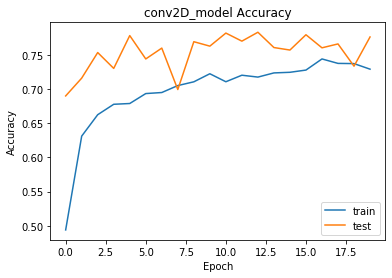

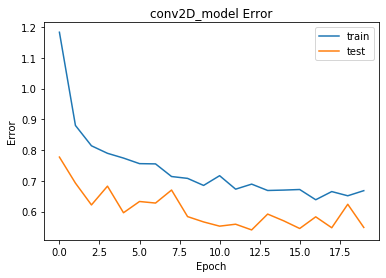


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.001 batch size 16/Model.h5
Training Initiated at 2020-03-15 13:20:23.952482


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 50,

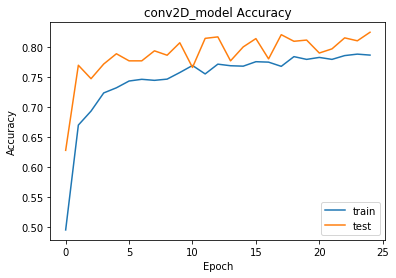

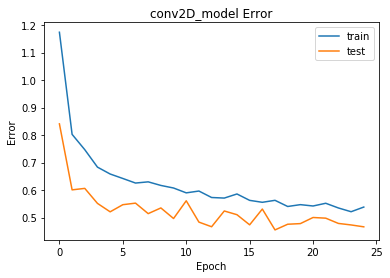


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.001 batch size 32/Model.h5
Training Initiated at 2020-03-15 13:24:28.088065


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 50,

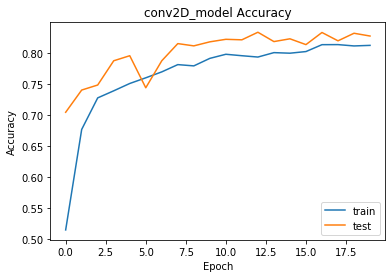

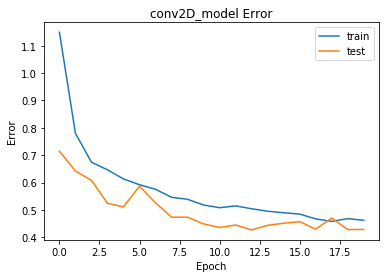


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.001 batch size 64/Model.h5
Training Initiated at 2020-03-15 13:27:19.399090


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 50,

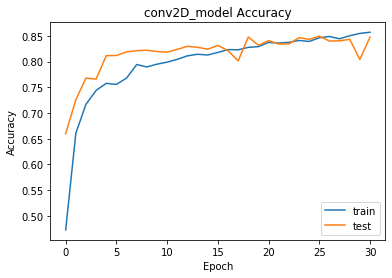

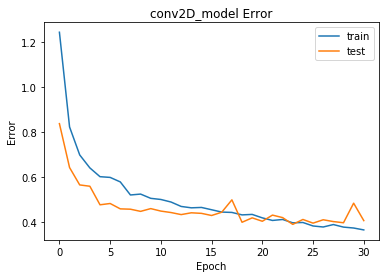


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.001 batch size 128/Model.h5
Training Initiated at 2020-03-15 13:31:18.303081


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_72 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 50

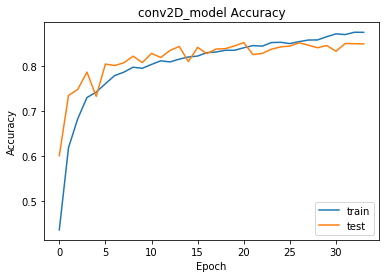

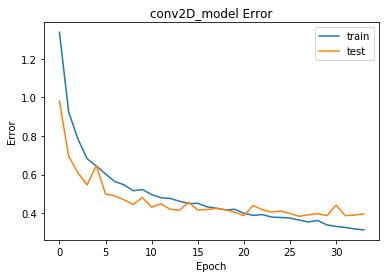


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.001 batch size 256/Model.h5
Training Initiated at 2020-03-15 13:35:32.099550


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 50

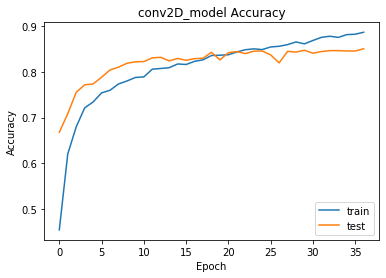

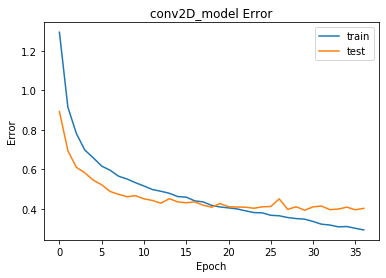


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.0001 batch size 16/Model.h5
Training Initiated at 2020-03-15 13:43:10.471273


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 50

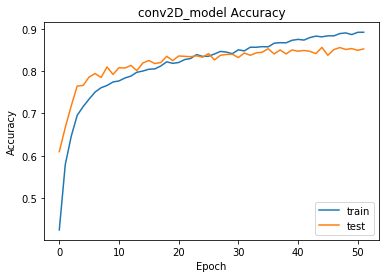

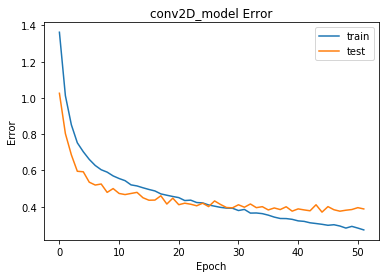


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.0001 batch size 32/Model.h5
Training Initiated at 2020-03-15 13:51:30.779319


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 50

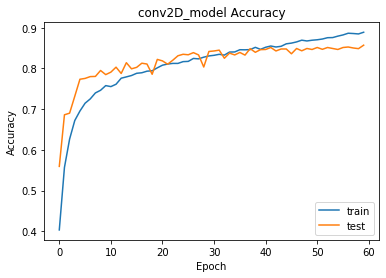

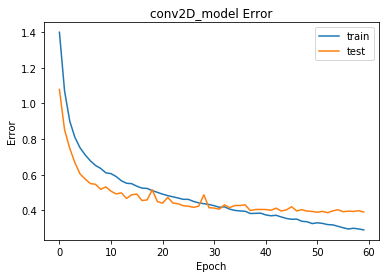


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.0001 batch size 64/Model.h5
Training Initiated at 2020-03-15 13:59:36.845078


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 50

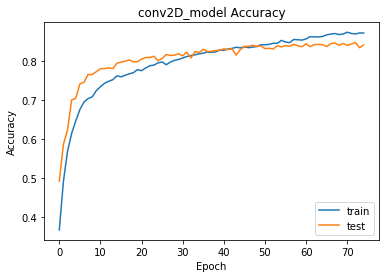

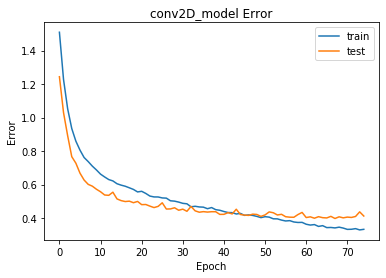


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.0001 batch size 128/Model.h5
Training Initiated at 2020-03-15 14:08:57.698670


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_92 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 5

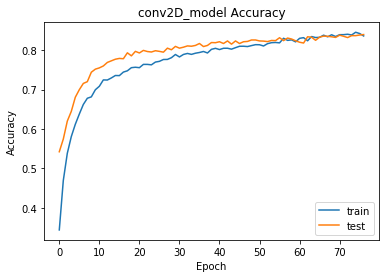

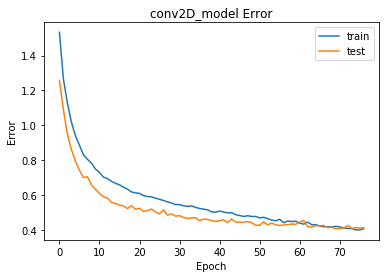


 
 Model is saved/content/drive/My Drive/TMP/Grid Search Dump/lr 0.0001 batch size 256/Model.h5
Training Initiated at 2020-03-15 14:18:16.897400


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 100, 30, 64)       1216      
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 100, 30, 64)       0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 50, 15, 64)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 50, 15, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 50, 15, 128)       73856     
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 5

In [0]:
result = {}
lr = [1e-3, 1e-4, 1e-5]
batch_size = [16,32,64,128,256]
saving_dir = '/content/drive/My Drive/TMP/Grid Search Dump/'

for rate in lr:
  for size in batch_size:
    result[rate, size] = grid_search(rate, size, saving_dir)

In [0]:
### I forgot to save the performance value, so I re-evaluate the model ----- ###
from tensorflow.keras.models import load_model

def get_loss_value(lr, batch_size, saving_dir):
  model_name = 'lr {} batch size {}/'.format(str(lr), str(batch_size)) 
  saving_dir = saving_dir+model_name
  model = load_model(saving_dir+"Model.h5")
  model.load_weights(saving_dir+"Model CP.hdf5")
  train_loss, _ = model.evaluate(X_train, y_train, verbose = 1)
  val_loss, _ = model.evaluate(X_val, y_val, verbose=1)
  return [train_loss, val_loss]

In [0]:
lr = [1e-3, 1e-4, 1e-5]
batch_size = [16,32,64,128,256]
saving_dir = '/content/drive/My Drive/TMP/Grid Search Dump/'

for rate in lr:
  for size in batch_size:
    result[rate, size].extend(get_loss_value(rate, size, saving_dir))

3075/3075 [==============================] - 1s 369us/sample - loss: 0.5536 - categorical_accuracy: 0.7759


In [0]:
result_df = pd.DataFrame.from_dict(result, orient='index', columns=['Training Accuracy', 'Test Accuracy','Training Time', 'Train Loss', 'Test Loss'])
result_df.reset_index(inplace=True)
result_df

,index,Training Accuracy,Test Accuracy,Training Time,Train Loss,Test Loss
0,"(0.001, 16)",0.775935,0.775285,00:04:00.286429,0.553386,0.566619
1,"(0.001, 32)",0.823415,0.810081,00:03:54.143106,0.442573,0.478144
2,"(0.001, 64)",0.839431,0.820163,00:02:41.075567,0.402719,0.461594
3,"(0.001, 128)",0.882602,0.838699,00:03:48.989453,0.303784,0.410235
4,"(0.001, 256)",0.894472,0.843902,00:04:03.598935,0.280451,0.393701
5,"(0.0001, 16)",0.900488,0.838699,00:07:28.270877,0.269716,0.385332
6,"(0.0001, 32)",0.916179,0.849106,00:08:10.231988,0.234223,0.379903
7,"(0.0001, 64)",0.908455,0.846179,00:07:55.915419,0.252859,0.376508
8,"(0.0001, 128)",0.895935,0.841626,00:09:10.172608,0.279910,0.406396
9,"(0.0001, 256)",0.860976,0.835122,00:09:08.929306,0.348453,0.417392


In [0]:
result_df.sort_values(by=['Test Accuracy'], ascending=False)

,index,Training Accuracy,Test Accuracy,Training Time,Train Loss,Test Loss
6,"(0.0001, 32)",0.916179,0.849106,00:08:10.231988,0.234223,0.379903
7,"(0.0001, 64)",0.908455,0.846179,00:07:55.915419,0.252859,0.376508
4,"(0.001, 256)",0.894472,0.843902,00:04:03.598935,0.280451,0.393701
8,"(0.0001, 128)",0.895935,0.841626,00:09:10.172608,0.279910,0.406396
3,"(0.001, 128)",0.882602,0.838699,00:03:48.989453,0.303784,0.410235
5,"(0.0001, 16)",0.900488,0.838699,00:07:28.270877,0.269716,0.385332
10,"(1e-05, 16)",0.876423,0.835447,00:35:06.276910,0.319937,0.410053
9,"(0.0001, 256)",0.860976,0.835122,00:09:08.929306,0.348453,0.417392
2,"(0.001, 64)",0.839431,0.820163,00:02:41.075567,0.402719,0.461594
11,"(1e-05, 32)",0.840000,0.817236,00:23:12.942720,0.401303,0.453318


In [0]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/TMP/Best Model/Best Model.h5')
model.load_weights('/content/drive/My Drive/TMP/Best Model/Best Model CP.hdf5')
prediction = model.predict(conv2D_test_reshaped, batch_size = 32, verbose = 1)
prediction_result = np.argmax(np.round(prediction), axis=1)

1754/1754 [==============================] - 2s 976us/sample


In [0]:
display(prediction_result)

array([1, 1, 1, ..., 1, 5, 5])

In [0]:
np.savetxt("/content/drive/My Drive/TMP/Best Model/answer.txt", prediction_result, fmt="%s")

## 2D Convolutional + LSTM
To avoid confusion, for each algorithms, we redo the whole data management routines with different naming. From our evaluation, we find that our model yield in 83.13% accuracy in training and 80.65% accuracy in validation set. Training time for this model is 12 minutes and 55 seconds.

In [0]:
### ------------------------------------------------------------------------ ###
### ---------------------   Load necessary libraries   --------------------- ###
### ------------------------------------------------------------------------ ###

from sklearn.preprocessing import LabelEncoder, StandardScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, Reshape, CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### ------------------------------------------------------------------------ ###
### ---------------------   Data management routines   --------------------- ###
### ------------------------------------------------------------------------ ###

### Split dataset_train into training data and training label -------------- ###
lstm_trainsgn = dataset_train[0]
lstm_trainlbl = dataset_train[1]

### Do the same for dataset_test ------------------------------------------- ###
lstm_test = dataset_test[0]

### Reshape and scale the input -------------------------------------------- ###
rows, channel, freq, time = lstm_trainsgn.shape[0], lstm_trainsgn.shape[1], lstm_trainsgn.shape[2], lstm_trainsgn.shape[3]
lstm_trainsgn = lstm_trainsgn.reshape(rows, channel * freq * time)
ss = StandardScaler()
lstm_trainsgn = ss.fit_transform(lstm_trainsgn)
lstm_trainsgn = lstm_trainsgn.reshape(rows, freq * time, channel)

rows, channel, freq, time = lstm_test.shape[0], lstm_test.shape[1], lstm_test.shape[2], lstm_test.shape[3]
lstm_test = lstm_test.reshape(rows, channel * freq * time)
lstm_test = ss.transform(lstm_test)
lstm_test = lstm_test.reshape(rows, freq * time, channel)


### Convert training label into categorical -------------------------------- ###
le = LabelEncoder()
lstm_trainlbl = le.fit_transform(lstm_trainlbl)

### Split dataset into training and validation set ------------------------- ###
X_train, X_val, y_train, y_val = train_test_split(lstm_trainsgn, cat_label,
                                                  test_size = 0.2,
                                                  random_state = 24,
                                                  stratify = label)

Training Initiated at 2020-02-18 13:25:27.047336


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 3000, 64)          17408     
_________________________________________________________________
reshape_2 (Reshape)          (None, 100, 30, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 30, 270)      846990    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 30, 270)      1822770   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 6, 270)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 6, 120)        810120    
_________________________________________________________________
con

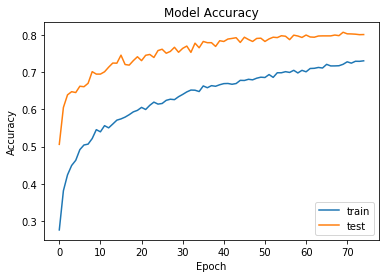

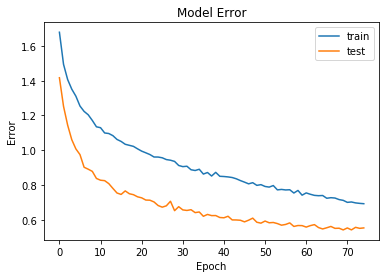

In [0]:
### ------------------------------------------------------------------------ ###
### ------------------------   Training the Model   ------------------------ ###
### ------------------------------------------------------------------------ ###

### Create Time Stamp ------------------------------------------------------ ###
start = datetime.now()
print("="*80)
print("Training Initiated at", start)
print("="*80,"\n\n")

### Define the model ------------------------------------------------------- ###

lstm_model = Sequential()

lstm_model.add(CuDNNLSTM(64, input_shape = X_train.shape[1:], return_sequences = True))
lstm_model.add(Reshape((100, 30, 64)))
lstm_model.add(Conv2D(270, kernel_size=(7,7), strides=(1,1), padding='same',
                 activation= 'relu'))
lstm_model.add(Conv2D(270, kernel_size=(5,5), strides=(1,1), padding='same', 
                 activation= 'relu'))
lstm_model.add(MaxPooling2D(pool_size=(5,5)))
lstm_model.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), padding='same', 
                 activation= 'relu'))
lstm_model.add(Conv2D(120, kernel_size=(5,5), strides=(1,1), padding='same', 
                 activation= 'relu'))
lstm_model.add(Flatten())
lstm_model.add(Dense(90, activation = "relu"))
lstm_model.add(Dense(60, activation = "relu"))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(30, activation = "relu"))
lstm_model.add(Dense(15, activation = "relu"))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(6, activation = 'softmax'))

lstm_model.summary()

lstm_model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(lr = 1e-5, decay = 1e-10),
              metrics = ["sparse_categorical_accuracy"])


cb = [ModelCheckpoint(
        filepath="/content/drive/My Drive/TMP/Model Checkpoint1.hdf5",
        verbose=1, save_best_only=True),
      EarlyStopping(monitor = "val_loss", patience = 5, mode = "min", verbose = 1)]
lstm_model_result = model.fit(X_train, y_train, epochs = 1000, batch_size = 32,
                           validation_data = (X_val, y_val),
                           callbacks = cb, verbose = 1)

# Checkpoint
cp = datetime.now() - start
print("="*80)
print("Training time", cp)
print("="*80,"\n\n")

# Model Evaluation
# Load the best weight model
lstm_model.load_weights("/content/drive/My Drive/TMP/Model Checkpoint1.hdf5")
_, train_acc = lstm_model.evaluate(X_train, y_train, verbose=1)
_, val_acc = lstm_model.evaluate(X_val, y_val, verbose=1)
print("\n\n")
print("="*80)
print("Evaluation on the best model")
print('Train: %.3f \nTest: %.3f' % (train_acc, val_acc))
print("="*80, "\n")

plt.plot(lstm_model_result.history['sparse_categorical_accuracy'], label='train')
plt.plot(lstm_model_result.history['val_sparse_categorical_accuracy'], label='test')
plt.title("Model Accuracy")
plt.legend(["train", "test"], loc = "lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
print("\n")
print("="*80, "\n")


plt.plot(lstm_model_result.history['loss'], label='train')
plt.plot(lstm_model_result.history['val_loss'], label='test')
plt.title("Model Error")
plt.legend(["train", "test"], loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [0]:
prediction = lstm_model.predict(lstm_test, batch_size = 32, verbose = 1)
prediction_result = np.argmax(np.round(prediction), axis=1)

1754/1754 [==============================] - 3s 2ms/sample


In [0]:
prediction_result

array([1, 2, 0, ..., 1, 5, 1])

In [0]:
np.savetxt("/content/drive/My Drive/Deep Learning Challenge/Ridwan_lstm/answer 2.txt", prediction_result, fmt="%s")

# Conclusion
In spite of good training and validation accuracy, our model did not perform well when we upload our prediction to the competition server. We suspect this is due to the difference in data distribution between our training and test data. Full model summary is detailed as follows:

Model | Training Accuracy | Validation Accuracy | Codalab accuracy
---- | ---- | ---- | ----
2D Convolution | 92.7% | 85.7% | 64.9%
2D Convolution + LSTM | 83.1% | 80.7% | 65.6%